##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API - read a PDF

This notebook demonstrates how you can convert a PDF file so that it can be read by the Gemini API.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/PDF_Files.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

In [ ]:
!pip install -Uq google-generativeai

In [ ]:
import google.generativeai as genai


import pathlib
import tqdm
import os

In [ ]:
from google.colab import userdata
genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))

Install the PDF processing tools:

In [ ]:
!apt install poppler-utils

## Download and proces the PDF

This textbook is from OpenStax, it's License is Commons Attribution License v4.0. More detrails are [available on the site](https://openstax.org/details/books/university-physics-volume-2).

In [2]:
import pathlib

In [3]:
if not pathlib.Path('test.pdf').exists():
    !curl -o test.pdf https://assets.openstax.org/oscms-prodcms/media/documents/UniversityPhysicsVolume2-WEB_5eNhMSa.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 59.2M  100 59.2M    0     0  63.6M      0 --:--:-- --:--:-- --:--:-- 63.5M


You'll extract Chapter 3, pages [121-154].

In [4]:
first = 121
last = 154

In [5]:
!mkdir output
! # extract images of Chapter 3
!pdftoppm test.pdf -f {first} -l {last} output/images -jpeg
!ls output

images-121.jpg	images-128.jpg	images-135.jpg	images-142.jpg	images-149.jpg
images-122.jpg	images-129.jpg	images-136.jpg	images-143.jpg	images-150.jpg
images-123.jpg	images-130.jpg	images-137.jpg	images-144.jpg	images-151.jpg
images-124.jpg	images-131.jpg	images-138.jpg	images-145.jpg	images-152.jpg
images-125.jpg	images-132.jpg	images-139.jpg	images-146.jpg	images-153.jpg
images-126.jpg	images-133.jpg	images-140.jpg	images-147.jpg	images-154.jpg
images-127.jpg	images-134.jpg	images-141.jpg	images-148.jpg


Look at the first image, scaled down:

In [6]:
import PIL.Image

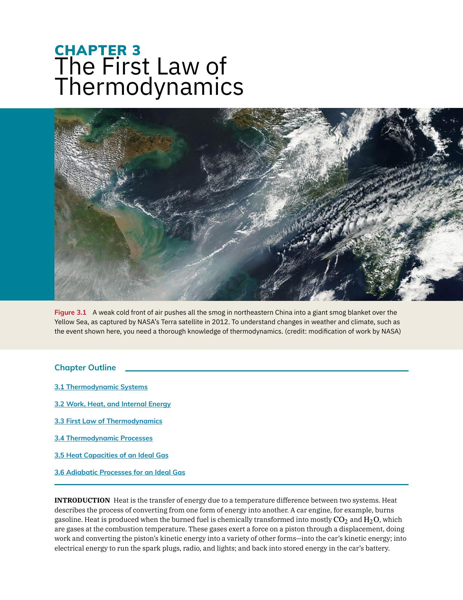

In [7]:
img = PIL.Image.open(f"output/images-{first}.jpg")
img.thumbnail([600, 600])
img

Extract the text for those same pages.

In [8]:
for page_number in range(first,last+1):
  page_number = f"{page_number:03d}"
  ! pdftotext  test.pdf -f {page_number} -l {page_number}
  ! mv test.txt output/text-{page_number}.txt

In [9]:
!ls output

images-121.jpg	images-135.jpg	images-149.jpg	text-129.txt  text-143.txt
images-122.jpg	images-136.jpg	images-150.jpg	text-130.txt  text-144.txt
images-123.jpg	images-137.jpg	images-151.jpg	text-131.txt  text-145.txt
images-124.jpg	images-138.jpg	images-152.jpg	text-132.txt  text-146.txt
images-125.jpg	images-139.jpg	images-153.jpg	text-133.txt  text-147.txt
images-126.jpg	images-140.jpg	images-154.jpg	text-134.txt  text-148.txt
images-127.jpg	images-141.jpg	text-121.txt	text-135.txt  text-149.txt
images-128.jpg	images-142.jpg	text-122.txt	text-136.txt  text-150.txt
images-129.jpg	images-143.jpg	text-123.txt	text-137.txt  text-151.txt
images-130.jpg	images-144.jpg	text-124.txt	text-138.txt  text-152.txt
images-131.jpg	images-145.jpg	text-125.txt	text-139.txt  text-153.txt
images-132.jpg	images-146.jpg	text-126.txt	text-140.txt  text-154.txt
images-133.jpg	images-147.jpg	text-127.txt	text-141.txt
images-134.jpg	images-148.jpg	text-128.txt	text-142.txt


In [10]:
!cat output/text-{first}.txt

CHAPTER 3

The First Law of
Thermodynamics

Figure 3.1 A weak cold front of air pushes all the smog in northeastern China into a giant smog blanket over the
Yellow Sea, as captured by NASA’s Terra satellite in 2012. To understand changes in weather and climate, such as
the event shown here, you need a thorough knowledge of thermodynamics. (credit: modification of work by NASA)

Chapter Outline
3.1 Thermodynamic Systems
3.2 Work, Heat, and Internal Energy
3.3 First Law of Thermodynamics
3.4 Thermodynamic Processes
3.5 Heat Capacities of an Ideal Gas
3.6 Adiabatic Processes for an Ideal Gas

INTRODUCTION Heat is the transfer of energy due to a temperature difference between two systems. Heat
describes the process of converting from one form of energy into another. A car engine, for example, burns
gasoline. Heat is produced when the burned fuel is chemically transformed into mostly
and
which
are gases at the combustion temperature. These gases exert a force on a piston through a displacem

## Assemble the files into a prompt

Upload all the files using the files API, there are too many to send with the `generate_content` request.

In [11]:
files = []
image_files = list(pathlib.Path("output").glob('images-*.jpg'))
for img in tqdm.tqdm(image_files):
    files.append(genai.upload_file(img))

100%|██████████| 34/34 [00:50<00:00,  1.48s/it]


Load all the texts:

In [12]:
texts = [t.read_text() for t in pathlib.Path("output").glob('text-*.txt')]

Interleave the page-numbers, texts, and image-file references:

In [13]:
textbook = []
for page, (text, image) in enumerate(zip(texts, files)):
  textbook.append(f'## Page {first+page} ##')
  textbook.append(text)
  textbook.append(image)

## Try it out

In [14]:
model = genai.GenerativeModel(model_name='gemini-1.5-flash')

In [15]:
response = model.generate_content(
    ['# Here is a chapter from a physics text book:']+
    textbook +
    ["[END]\n\nPlease sumarize it in sections for a better understanding"]
)

In [16]:
from IPython.display import Markdown
Markdown(response.text)

## Chapter 3: The First Law of Thermodynamics

### 3.1 Thermodynamic Systems
* **Thermodynamic System:** A system is any part of the universe whose properties are of interest. 
* **Boundary:** The boundary separates the system from its surroundings.
* **Surroundings:** The environment that interacts with the system.
* **Closed System:** A system that is isolated from its environment.
* **Open System:** A system that can exchange energy and/or matter with its surroundings.
* **Thermal Equilibrium:** Two objects are in thermal equilibrium if they are at the same temperature and the net heat transfer between them is zero.
* **Equation of State:** A mathematical relationship that describes the properties of a system under given physical conditions.

### 3.2 Work, Heat, and Internal Energy
* **Work Done by a System:** When a system expands, it does work on its surroundings. When a system is compressed, work is done on the system.
* **Heat:** Energy transferred between two objects or parts of a system due to a temperature difference.
* **Internal Energy:** The average of the total mechanical energy of all the molecules or entities in the system.
* **Quasi-static Process:** A process that occurs so slowly that the system is always in thermodynamic equilibrium.
* **Isothermal Process:** A process during which the system's temperature remains constant.
* **Adiabatic Process:** A process during which no heat is transferred to or from the system.
* **Isobaric Process:** A process during which the system's pressure remains constant.
* **Isochoric Process:** A process during which the system's volume remains constant.

### 3.3 First Law of Thermodynamics
* **First Law of Thermodynamics:** The change in the internal energy of a thermodynamic system is equal to the heat added to the system less the work done by the system.
* **State Functions:** Functions that depend only on the state of the system, such as internal energy and potential energy.

### 3.4 Thermodynamic Processes
* **Thermodynamic Process:** The manner in which a state of a system changes from the initial state to the final state.
* **Quasi-static and Non-quasi-static Processes:** A quasi-static process is an idealized process that occurs infinitesimally slowly, while a non-quasi-static process occurs more rapidly.

### 3.5 Heat Capacities of an Ideal Gas
* **Molar Heat Capacity at Constant Pressure (Cp):** The ratio of the amount of heat added or removed to the temperature change at constant pressure.
* **Molar Heat Capacity at Constant Volume (Cv):** The ratio of the amount of heat added or removed to the temperature change at constant volume.
* **Adiabatic Processes for an Ideal Gas:** An adiabatic process is one in which no heat is transferred to or from the system. During an adiabatic expansion, an ideal gas does work and its temperature drops. During an adiabatic compression, an ideal gas has work done on it and its temperature increases.

### Conceptual Questions
* **Thermodynamic Systems:**
    * Is it possible to determine whether a change in internal energy is caused by heat transferred, by work performed, or by a combination of the two?
    * When a liquid is vaporized, its change in internal energy is not equal to the heat added. Why?
* **Work, Heat, and Internal Energy:**
    * Why does a bicycle pump feel warm as you inflate your tire?
* **First Law of Thermodynamics:**
    * What does the first law of thermodynamics tell us about the energy of the universe?
    * Does adding heat to a system always increase its internal energy?
* **Thermodynamic Processes:**
    * When a gas expands isothermally, it does work. What is the source of energy needed to do this work?
    * If the pressure and volume of a system are given, is the temperature always uniquely determined?
    * It is unlikely that a process can be isothermal unless it is a very slow process. Explain why. Is the same true for isobaric and isochoric processes? Explain your answer.
* **Heat Capacities of an Ideal Gas:**
    * How can an object transfer heat if the object does not possess a discrete quantity of heat?
    * Most materials expand when heated. One notable exception is water between 0°C and 4°C, which actually decreases in volume with the increase in temperature. Which is greater for water in this temperature region, Cp or Cv?
    * Why are there two specific heats for gases (Cp and Cv), yet only one given for solids?
* **Adiabatic Processes for an Ideal Gas:**
    * Is it possible for
    to be smaller than unity?
    * Would you expect
    to be larger for a gas or a solid? Explain.
    * There is no change in the internal energy of an ideal gas undergoing an isothermal process since the internal energy depends only on the temperature. Is it therefore correct to say that an isothermal process is the same as an adiabatic process for an ideal gas? Explain your answer.
    * Does a gas do any work when it expands adiabatically? If so, what is the source of the energy needed to do this work?

### Problems
* **Thermodynamic Systems:**
    * A gas follows pV^b = c on an isothermal curve, where p is the pressure, V is the volume, b is a constant, and c is a function of temperature. Show that a temperature scale under an isochoric process can be established with this gas and is identical to that of an ideal gas.
* **Work, Heat, and Internal Energy:**
    * A gas at a pressure of 2.00 atm undergoes a quasi-static isobaric expansion from 3.00 to 5.00 L. How much work is done by the gas?
    * It takes 500 J of work to compress quasi-statically 0.50 mol of an ideal gas to one-fifth its original volume. Calculate the temperature of the gas, assuming it remains constant during the compression.
* **Thermodynamic Processes:**
    * The state of 30 moles of steam in a cylinder is changed in a cyclic manner from a-b-c-a, where the pressure and volume of the states are: a (30 atm, 20 L), b (50 atm, 20 L), and c (50 atm, 45 L). Assume each change takes place along the line connecting the initial and final states in the pV plane. (a) Display the cycle in the pV plane. (b) Find the net work done by the steam in one cycle. (c) Find the net amount of heat flow in the steam over the course of one cycle.
* **Heat Capacities of an Ideal Gas:**
    * The temperature of an ideal monatomic gas rises by 8.0 K. What is the change in the internal energy of 1 mol of the gas at constant volume?
* **Adiabatic Processes for an Ideal Gas:**
    * A monatomic ideal gas undergoes a quasi-static adiabatic expansion in which its volume is doubled. How is the pressure of the gas changed?
    * An ideal gas has a pressure of 0.50 atm and a volume of 10 L. It is compressed adiabatically and quasi-statically until its pressure is 3.0 atm and its volume is 2.8 L. Is the gas monatomic, diatomic, or polyatomic?
    * Pressure and volume measurements of a dilute gas undergoing a quasi-static adiabatic expansion are shown below. Plot ln p vs. V and determine
    for this gas from your graph.

